## Сбор данных (создание веб-краулера)

In [63]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    #print(row_date)
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам (на сайте Яндекс Дзен)

In [64]:
def parse_rubrics():
    rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']
    rubrics_links = ['rubric/politics', 'rubric/society', 'rubric/business', 'rubric/world', 'rubric/sport', 'rubric/incident', 'rubric/culture', 'rubric/computers', 'rubric/science']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

#parse_rubrics()

### Сбор похожих новостей при переходе к каждой новости (на сайте Яндекс Дзен)

In [65]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

#parse_main()

### Сохранение и чтение данных в формате xlsx

In [66]:
df1 = parse_main()

# Для mac
df1.to_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df1.to_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

In [67]:
# Для mac
df2 = pd.read_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df2 = pd.read_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

# Выражение, добавляющее к БД только новые новости
res = df1[~df1['url'].isin(df2['url'])]

#res
#df1

## Разведочный анализ данных EDA

In [68]:
# Объем данных (строк и столбцов - объектов и признаков)
df1.shape

(1814, 8)

In [69]:
# Вывод типов данных
df1.dtypes

rubric         object
story_id       object
title          object
text           object
sourceName     object
instory_url    object
url            object
time           object
dtype: object

<div class="alert alert-success"><b>Целевой признак - rubric</b>

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rubric       1814 non-null   object
 1   story_id     1814 non-null   object
 2   title        1814 non-null   object
 3   text         1814 non-null   object
 4   sourceName   1814 non-null   object
 5   instory_url  1814 non-null   object
 6   url          1814 non-null   object
 7   time         1814 non-null   object
dtypes: object(8)
memory usage: 113.5+ KB


<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [71]:
# Имена колонок в виде списков
df1.columns

Index(['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url',
       'url', 'time'],
      dtype='object')

In [72]:
# Кол-во пропусков во всем датафрейме
df1.isnull().sum()

rubric         0
story_id       0
title          0
text           0
sourceName     0
instory_url    0
url            0
time           0
dtype: int64

In [73]:
# Статистика распределения этих значений в % виде
df1['rubric'].value_counts(normalize=True)

Происшествия    0.372106
Культура        0.110805
Политика        0.100882
Общество        0.085998
В мире          0.082139
Экономика       0.068357
Спорт           0.062293
Наука           0.061742
Технологии      0.055678
Name: rubric, dtype: float64

In [74]:
# Исследование целевого (target) признака - рубрики 
print('Кол-во уникальных значений: ', df1['rubric'].nunique())
print('Список уникальных значений: ', df1['rubric'].unique())
print('Статистика распределения значений: ', df1['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Происшествия    675
Культура        201
Политика        183
Общество        156
В мире          149
Экономика       124
Спорт           113
Наука           112
Технологии      101
Name: rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [75]:
# Описательная статистика для признака rubric
df1['rubric'].describe()

count             1814
unique               9
top       Происшествия
freq               675
Name: rubric, dtype: object

In [76]:
# Описательная статистика для всех признаков 
df1.describe().T

,count,unique,top,freq
rubric,1814,9,Происшествия,675
story_id,1814,255,705800408,100
title,1814,1710,Три человека погибли при взрыве бензовоза на а...,8
text,1814,1768,На аэродроме под Рязанью взорвался бензовоз.,4
sourceName,1814,566,Lenta.ru,44
instory_url,1814,261,https://dzen.ru/news/instory/Privzryve_naaehro...,100
url,1814,1785,https://oilcapital.ru/news/2022-12-05/sloveniy...,2
time,1814,677,06.12.2022 16:05,18


### Визульный анализ

<AxesSubplot:>

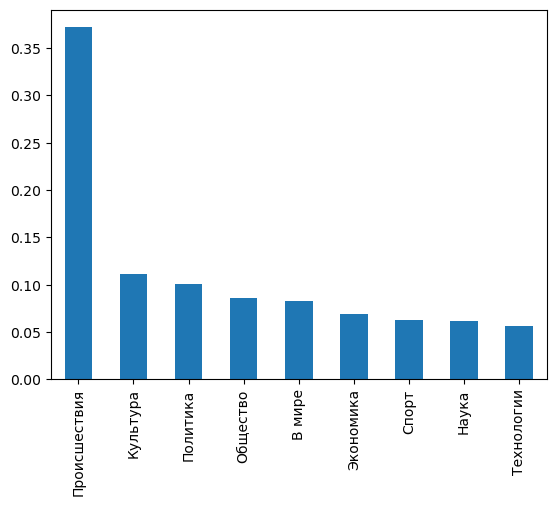

In [77]:
# Столбчатая диаграмма
# По оси y - доля в %, по x - сами рубрики
# Если поменять normalize=True на normalize=False, то ось y будет в кол-ом значении

df1['rubric'].value_counts(normalize=True).plot.bar()

<AxesSubplot:ylabel='rubric'>

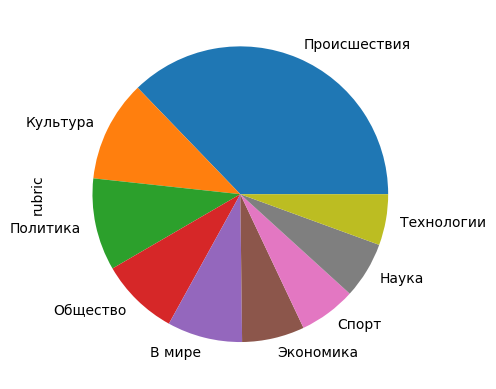

In [78]:
# Круговая(пирожковая) диаграмма
df1['rubric'].value_counts(normalize=True).plot.pie()

<AxesSubplot:>

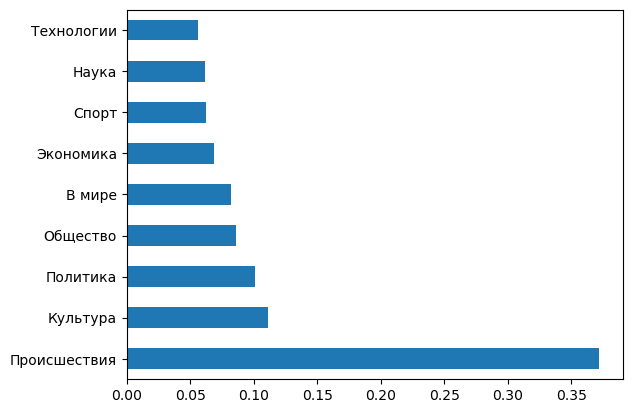

In [79]:
# Горизонтальная столбчатая диаграмма
df1['rubric'].value_counts(normalize=True).plot.barh()

In [80]:
df1['rubric'].value_counts()

Происшествия    675
Культура        201
Политика        183
Общество        156
В мире          149
Экономика       124
Спорт           113
Наука           112
Технологии      101
Name: rubric, dtype: int64

## Предварительная обработка данных (preprocessing). Обработка естественного языка NLP


Действия, выполняемые в процессе:
* сегментация и токенизация;
* стемминг;
* удаление стоп-слов;
* лемматизация.

### Удаление пробельных символов

In [81]:
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df1['text']]
    df_nlp = df1.loc[:, ['rubric','title','text']]
    df_nlp["text_prep"] = prep_text
    return df_nlp

### Стемминг

In [82]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    return df_nlp

def remove_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    return " ".join(tokens)

### Удаление стоп-слов

In [83]:
from nltk import word_tokenize

def stopword_text():
    sw_texts_list = []
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    return df_nlp

### Лемматизация

In [84]:
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    lemm_texts_list = []

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
    except Exception as e:
        print(e)

    text_split = text.split("joining")
    df_nlp["text_lemm"] = text_split
    return df_nlp

lemmatize_text()

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
0,Политика,Минобороны РФ: российские войска поразили все ...,"В сообщении военного ведомства отмечается, что...",в сообщении военного ведомства отмечается что ...,сообщен воен ведомств отмеча результат массиро...,сообщении военного ведомства отмечается резуль...,сообщение военный ведомство отмечаться результ...
1,Политика,Минобороны: нанесен удар по системе военного у...,"По его словам, в результате атак удалось добит...",по его словам в результате атак удалось добить...,слов результат атак уда доб прекращен выпуск р...,словам результате атак удалось добиться прекра...,словам результат атака удаваться добиваться пр...
2,Политика,Минобороны: ВС России нанесли удар по системе ...,Вчера российские войска нанесли массированный ...,вчера российские войска нанесли массированный ...,вчер российск войск нанесл массирова удар высо...,вчера российские войска нанесли массированный ...,вчера российский войско наносить массированный...
3,Политика,Минобороны: удары ВС России наносились по обор...,«5 декабря российскими войсками нанесен массир...,« декабря российскими войсками нанесен массиро...,декабр российск войск нанес массирова удар выс...,декабря российскими войсками нанесен массирова...,декабря российский войско наносить массированн...
4,Политика,ВС России нанесли 5 декабря удар по системе во...,Ранее премьер Украины Денис Шмыгаль ранее подт...,ранее премьер украины денис шмыгаль ранее подт...,ран премьер украин денис шмыгал ран подтверд п...,ранее премьер украины денис шмыгаль ранее подт...,ранее премьер украина денис шмыгаль ранее подт...
...,...,...,...,...,...,...,...
1773,Наука,Лекарства против тромбов станут дешевле для ап...,Ученые придумали теоретический расчет частей н...,ученые придумали теоретический расчет частей н...,учен придума теоретическ расчет част некотор д...,ученые придумали теоретический расчет частей н...,ученые придумывать теоретический расчет часть ...
1774,Наука,В СГУ разработан бюджетный метод проверки каче...,Русские учёные изобрели быструю и недорогую ме...,русские учёные изобрели быструю и недорогую ме...,русск учен изобрел быстр недорог методик прове...,русские учёные изобрели быструю недорогую мето...,русские ученый изобретать быстрый недорогой ме...
1775,Наука,Ученые из СГУ нашли дешевый способ проверки ка...,Ученые из Саратовского национального исследова...,ученые из саратовского национального исследова...,учен саратовск национальн исследовательск госу...,ученые саратовского национального исследовател...,ученые саратовский национальный исследовательс...
1776,Наука,Проверить безопасность лекарств против тромбов...,Ученые СГУ разработали легкий и доступный мето...,ученые сгу разработали легкий и доступный мето...,учен сгу разработа легк доступн метод контрол ...,ученые сгу разработали легкий доступный метод ...,ученые сгу разрабатывать легкий доступный мето...


In [85]:
def undersempler():
    df_pr = df_nlp.loc[df_nlp['rubric'] == 'Происшествия'].head(200)
    df_other = df_nlp.loc[df_nlp['rubric'] != 'Происшествия']

    df_ml = pd.concat([df_pr, df_other])
    return df_ml

<AxesSubplot:>

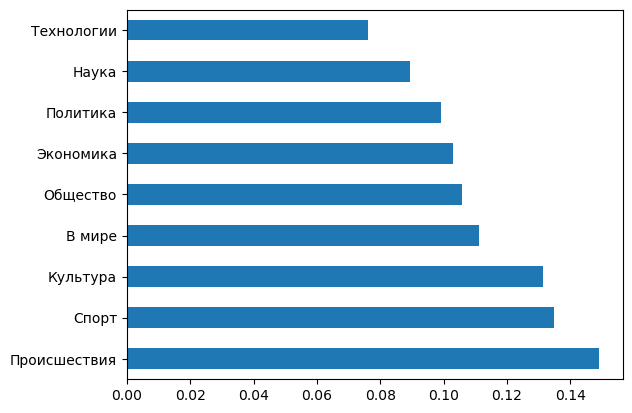

In [86]:
# Горизонтальная столбчатая диаграмма
df_ml['rubric'].value_counts(normalize=True).plot.barh()

## Создание моделей машинного обучения

### Кодирование целевой переменной. Формирование тестовой и обучающей выборок

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)

X = df_ml['text_lemm']
#X = df_nlp['text_sw']
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Байесовский классификатор

In [89]:
from sklearn.naive_bayes import MultinomialNB

def nb_classifier():
    
    nb = Pipeline ([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                   ])

    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

nb_classifier()

accuracy 0.8014888337468983
              precision    recall  f1-score   support

    Политика       0.80      0.64      0.71        50
    Общество       0.73      0.98      0.83        41
   Экономика       1.00      0.63      0.78        41
      В мире       0.78      0.53      0.63        47
       Спорт       0.95      0.93      0.94        45
Происшествия       0.65      1.00      0.79        51
    Культура       0.85      0.93      0.89        60
  Технологии       0.92      0.44      0.59        25
       Наука       0.80      0.93      0.86        43

    accuracy                           0.80       403
   macro avg       0.83      0.78      0.78       403
weighted avg       0.82      0.80      0.79       403



0.8

### Метод опорных векторов

In [90]:
from sklearn.linear_model import SGDClassifier

def sgd_classifier():
    
    sgd = Pipeline ([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                    ])

    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

sgd_classifier()

accuracy 0.8759305210918115
              precision    recall  f1-score   support

    Политика       0.80      0.72      0.76        50
    Общество       0.88      0.93      0.90        41
   Экономика       0.93      0.90      0.91        41
      В мире       0.79      0.70      0.74        47
       Спорт       0.91      0.96      0.93        45
Происшествия       0.93      1.00      0.96        51
    Культура       0.98      0.90      0.94        60
  Технологии       0.71      0.80      0.75        25
       Наука       0.85      0.95      0.90        43

    accuracy                           0.88       403
   macro avg       0.87      0.87      0.87       403
weighted avg       0.88      0.88      0.87       403



0.88

### Логистическая регрессия

In [91]:
from sklearn.linear_model import LogisticRegression

def logreg_classifier():

    logreg = Pipeline ([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                       ])

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

logreg_classifier()

accuracy 0.8635235732009926
              precision    recall  f1-score   support

    Политика       0.74      0.68      0.71        50
    Общество       0.95      0.90      0.92        41
   Экономика       0.95      0.88      0.91        41
      В мире       0.73      0.77      0.75        47
       Спорт       0.88      0.93      0.90        45
Происшествия       0.88      1.00      0.94        51
    Культура       0.96      0.88      0.92        60
  Технологии       0.76      0.76      0.76        25
       Наука       0.89      0.93      0.91        43

    accuracy                           0.86       403
   macro avg       0.86      0.86      0.86       403
weighted avg       0.86      0.86      0.86       403



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.86

### Дерево решений 

In [92]:
from sklearn.tree import DecisionTreeClassifier

def dtree_classifier():
    
    dtree = Pipeline ([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', DecisionTreeClassifier(max_depth = 2)),
                      ])

    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

dtree_classifier()

accuracy 0.18858560794044665
              precision    recall  f1-score   support

    Политика       0.00      0.00      0.00        50
    Общество       0.11      1.00      0.20        41
   Экономика       0.00      0.00      0.00        41
      В мире       0.00      0.00      0.00        47
       Спорт       0.00      0.00      0.00        45
Происшествия       0.95      0.35      0.51        51
    Культура       1.00      0.28      0.44        60
  Технологии       0.00      0.00      0.00        25
       Наука       0.00      0.00      0.00        43

    accuracy                           0.19       403
   macro avg       0.23      0.18      0.13       403
weighted avg       0.28      0.19      0.15       403



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.19

### Метод K ближайщих соседей KNN

#### Для n_neighbors=3

In [93]:
from sklearn.neighbors import KNeighborsClassifier

def knn3_classifier():

    knn3 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=3)),
                   ])

    knn3.fit(X_train, y_train)
    y_pred = knn3.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn3_classifier()

accuracy 0.8312655086848635
              precision    recall  f1-score   support

    Политика       0.66      0.74      0.70        50
    Общество       0.76      0.95      0.85        41
   Экономика       0.81      0.73      0.77        41
      В мире       0.80      0.74      0.77        47
       Спорт       0.89      0.89      0.89        45
Происшествия       0.86      0.96      0.91        51
    Культура       0.92      0.80      0.86        60
  Технологии       0.89      0.68      0.77        25
       Наука       0.95      0.93      0.94        43

    accuracy                           0.83       403
   macro avg       0.84      0.83      0.83       403
weighted avg       0.84      0.83      0.83       403



0.83

#### Для n_neighbors=9

In [94]:
from sklearn.neighbors import KNeighborsClassifier

def knn9_classifier():
    
    knn9 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=9)),
                   ])

    knn9.fit(X_train, y_train)
    y_pred = knn9.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn9_classifier()

accuracy 0.7890818858560794
              precision    recall  f1-score   support

    Политика       0.77      0.68      0.72        50
    Общество       0.78      0.95      0.86        41
   Экономика       0.86      0.76      0.81        41
      В мире       0.68      0.57      0.62        47
       Спорт       0.84      0.91      0.87        45
Происшествия       0.70      1.00      0.82        51
    Культура       0.94      0.78      0.85        60
  Технологии       0.88      0.56      0.68        25
       Наука       0.76      0.79      0.77        43

    accuracy                           0.79       403
   macro avg       0.80      0.78      0.78       403
weighted avg       0.80      0.79      0.78       403



0.79

### Метод градиентного бустинга

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score 

def gbr_classifier():
    
    gbr = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', GradientBoostingRegressor(n_estimators=200, max_depth=12, criterion='squared_error', learning_rate=0.03, min_samples_leaf=16, min_samples_split=16)),
                   ])

    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    train_accuracy_score=gbr.score(X_train,y_train)
    test_accuracy_score=gbr.score(X_test,y_test)
    mse = mean_squared_error(y_test,y_pred)

    print(train_accuracy_score)
    print(test_accuracy_score)
    print("MSE: %.2f" % mse)
    print(r2_score(y_test,y_pred))
    
    return round(test_accuracy_score, 2)

gbr_classifier()

0.5401138031298667
0.3349699158432443
MSE: 4.26
0.3349699158432443


0.33

In [100]:
from sklearn.metrics import confusion_matrix

cm = multilabel_confusion_matrix(y_test,y_pred, labels=rubrics)
cm

NameError: name 'multilabel_confusion_matrix' is not defined

![jupyter](https://pythonru.com/wp-content/uploads/2021/03/matrica-oshibok-dlya-binarnoj-klassifikacii.png)

True, если получено верное предсказание, то есть эталонные и предсказанные метки классов совпадают, и False, когда они не совпадают. Positive или Negative — названия предсказанных меток.

In [ ]:
# Пример рассчета характеристик для конкретного класса

# Чувствительность (recall)
print('TPR = %.2f' % (cm[1][1] / sum(cm[1])))

# Специфичность
print('SPC = %.2f' % (cm[0][0] / sum(cm[0])))

# Ценность + прогноза (precision)
print('PPV = %.2f' % (cm[1][1] / sum(col[1] for col in cm)))

# Ценность - прогноза
print('NPV = %.2f' % (cm[0][0] / sum(col[0] for col in cm)))

print('Acc = %.2f' % ((cm[0][0] + cm[1][1]) / sum(cm[0][])))